In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

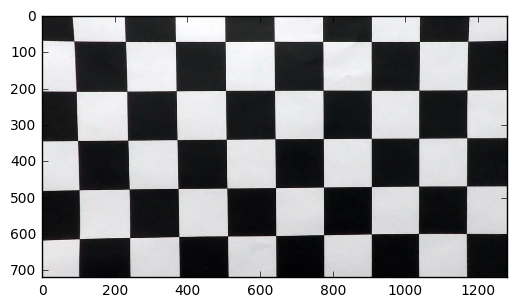

In [2]:
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
        #plt.show()
        
        
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist)
    return undist

test_image = cv2.imread('camera_cal/calibration1.jpg')
undist = cal_undistort(test_image, objpoints, imgpoints)


plt.imshow(undist)
plt.show()

In [3]:
img_size = (1280, 720)
src = np.float32([[  585.0-10,  460.0],
           [ 0.0,  720.0],
           [ 1280.0,  720.0],
           [ 695.0+10,  460.0]])

dst = np.float32([[320, 0], 
                  [320, 720],
                  [960, 720], 
                    [960, 0]])
        

M = cv2.getPerspectiveTransform(src, dst)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

def fast_unwarp_lane(img):
    undist = cv2.undistort(img, mtx, dist)
    out = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return out

def process_video(infile, outfile, method):
    clip1 = VideoFileClip(infile)
    white_clip = clip1.fl_image(method) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(outfile, audio=False)

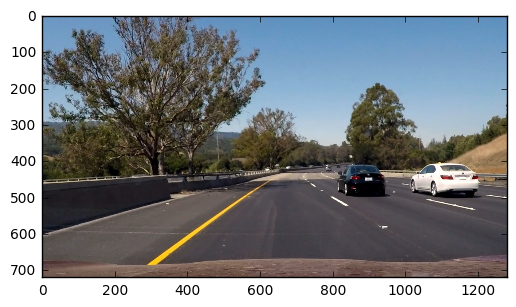

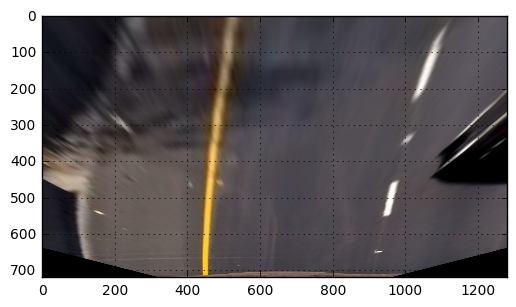

In [4]:
img = mpimg.imread('test_images/test6.jpg')
out = fast_unwarp_lane(img)

plt.imshow(img)
plt.show()

plt.imshow(out)
plt.grid(True)
plt.show()

# Unwarped Video

lets check how the complete video will look like and make sure all turns are covered in the frame.

In [309]:
inp = "project_video"
#inp = "challenge_video"

process_video(infile=inp + ".mp4", 
              outfile=inp + "_px.mp4", 
              method=fast_unwarp_lane)

[MoviePy] >>>> Building video project_video_px.mp4
[MoviePy] Writing video project_video_px.mp4


100%|█████████▉| 1260/1261 [01:13<00:00, 17.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_px.mp4 

CPU times: user 8min 7s, sys: 3.88 s, total: 8min 11s
Wall time: 1min 13s


# Masking Lanes

lets first conserve the yellow and white lanes as much as possible and filter all unwanted parts of the image.

`mask_image` method does this job. 

In [105]:

def plot_images(images):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(10*n, 10))
    for ix, img in enumerate(images):
        axes[ix].imshow(img, cmap='gray')
        axes[ix].axis('off')
    plt.show()


def abs_sobel_thresh(img_gray, orient='x', ksize=3,  thresh=(20,100)):    
    sobel = None
    if orient=='x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    else:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    
    return binary_output    
    
def mag_thresh(gray, ksize=9, thresh=(20,80)):    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abssolxy = np.sqrt(sobelx ** 2 + sobely ** 2)    
    scaledxy = (abssolxy*255/np.max(abssolxy)).astype(np.uint8)
    binary_output = np.zeros_like(scaledxy)
    binary_output[(scaledxy >= thresh[0]) & (scaledxy <= thresh[1])] = 1
    return binary_output
    
def dir_thresh(gray, ksize=15, thresh=(0.0, np.pi/2)):    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    abssobelx = np.absolute(sobelx)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abssobely = np.absolute(sobely)
    
    abssobelxy = np.arctan2(abssobely,abssobelx)

    binary_output = np.zeros_like(abssobelxy)
    binary_output[(abssobelxy >= thresh[0]) & (abssobelxy <= thresh[1])] = 1
    return binary_output

def hls_select(image_hsv):
    i_h = image_hsv[:,:,0]
    i_s = image_hsv[:,:,1]
    i_v = image_hsv[:,:,2]
    
    res = np.zeros_like(i_h).astype(np.uint8)
    res[((i_h > 0) & (i_h < 80)) & (i_s > 0.313) & (i_v > 0.39)]  = 1 #yellow only
    res[(i_s < 0.156) & (i_v > 0.7)]  = 1 #white only
    
    return res

def apply_stage_1(img_gray):
    x_image = abs_sobel_thresh(img_gray, orient='x', ksize=3, thresh=(20,100))
    y_image = abs_sobel_thresh(img_gray, orient='y', ksize=3, thresh=(20,100))
    xy_image = mag_thresh(img_gray, ksize=9, thresh=(20,100))
    dir_image = dir_thresh(img_gray, ksize=9, thresh=(0.7, 1.3))

    img_stage_1 = np.zeros_like(x_image)
    img_stage_1[((x_image == 1) & (y_image == 1)) | ((xy_image == 1) & (dir_image == 1))]  = 1
    return img_stage_1


def apply_thresholds(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    stage_1 = apply_stage_1(img_gray)
    stage_2 = hls_select(img_hsv)
    
    return stage_1, stage_2
    """
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    return mask, masked_image
    #return white_mask, cv2.bitwise_and(image,image, mask=white_mask) to investigate only on
    """


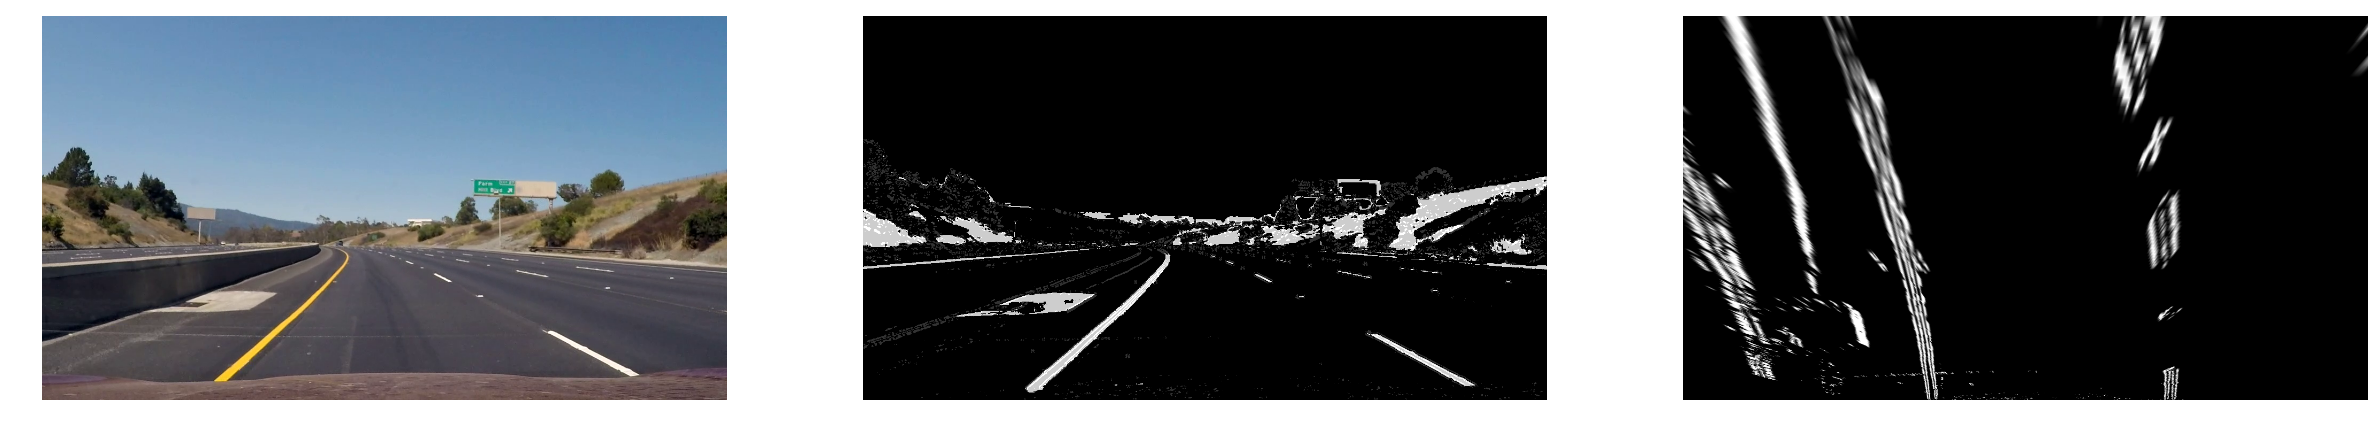

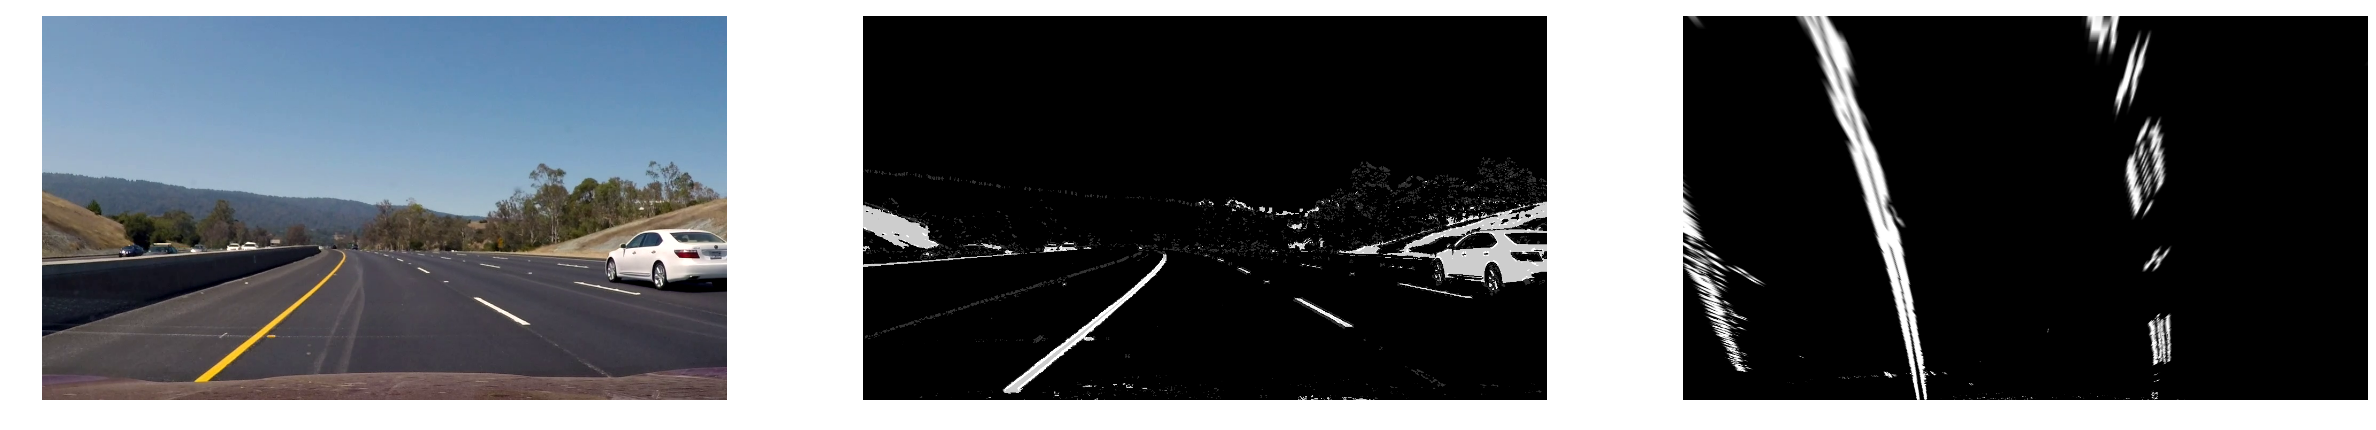

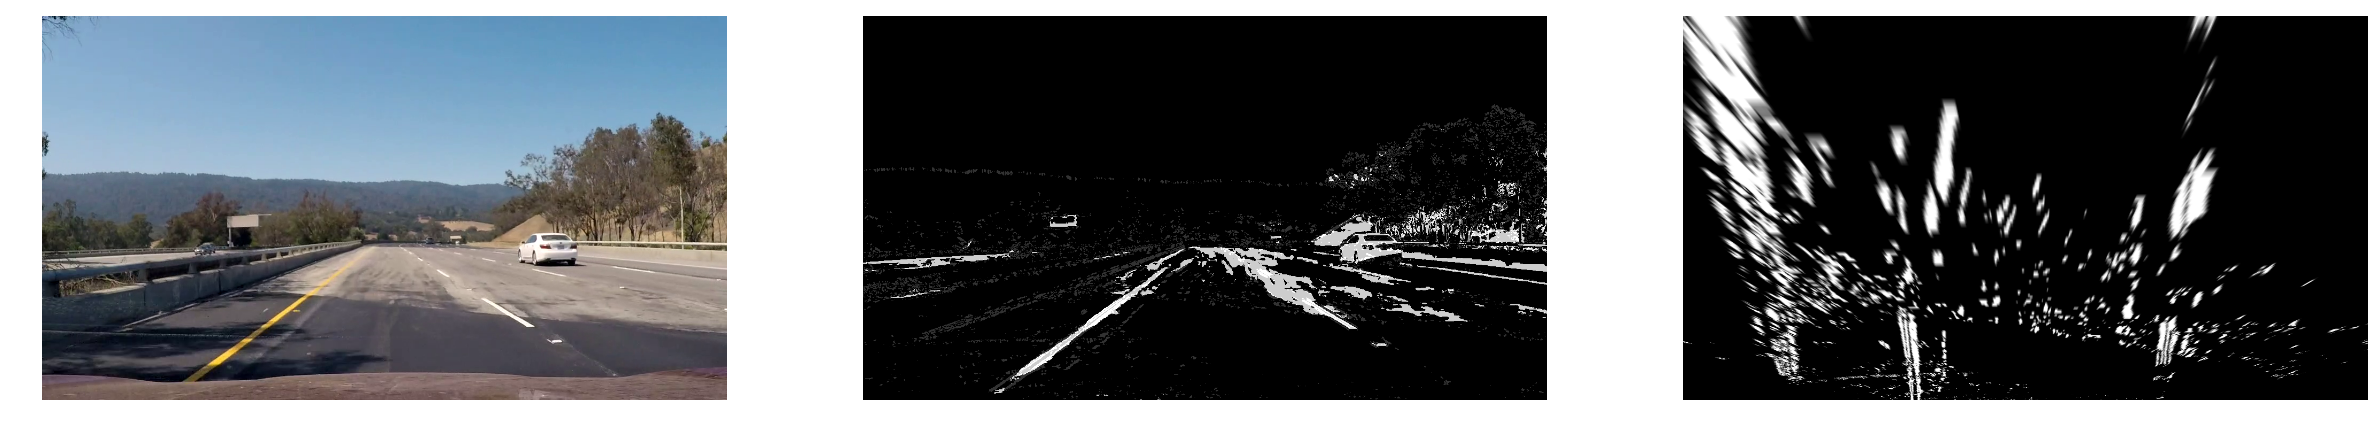

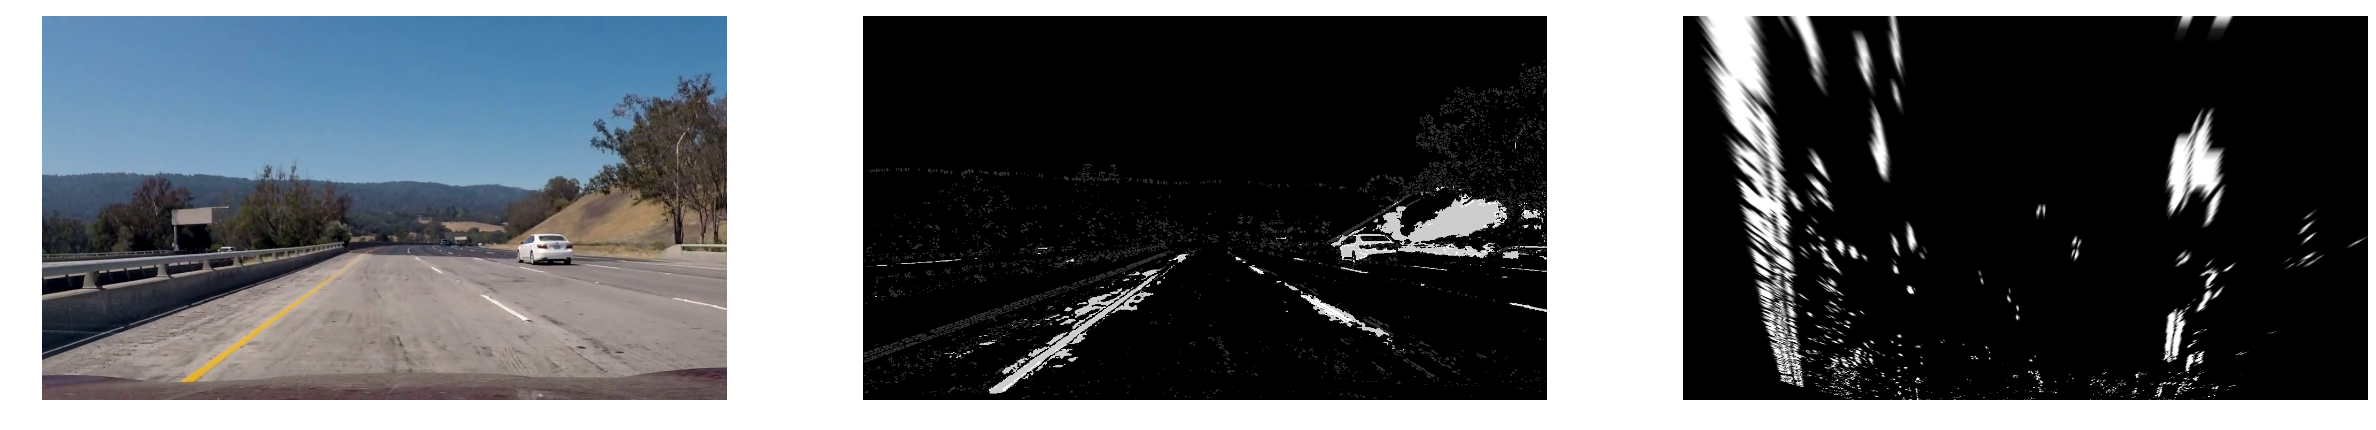

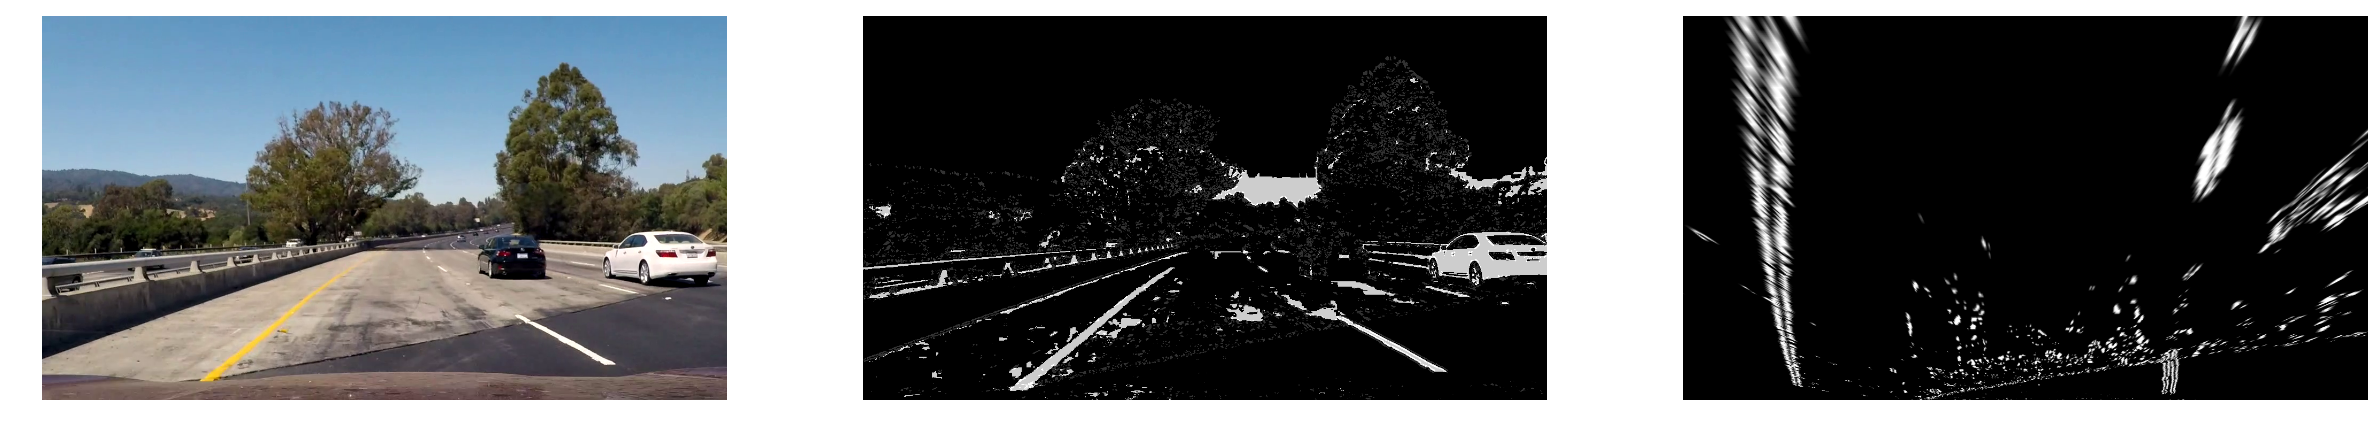

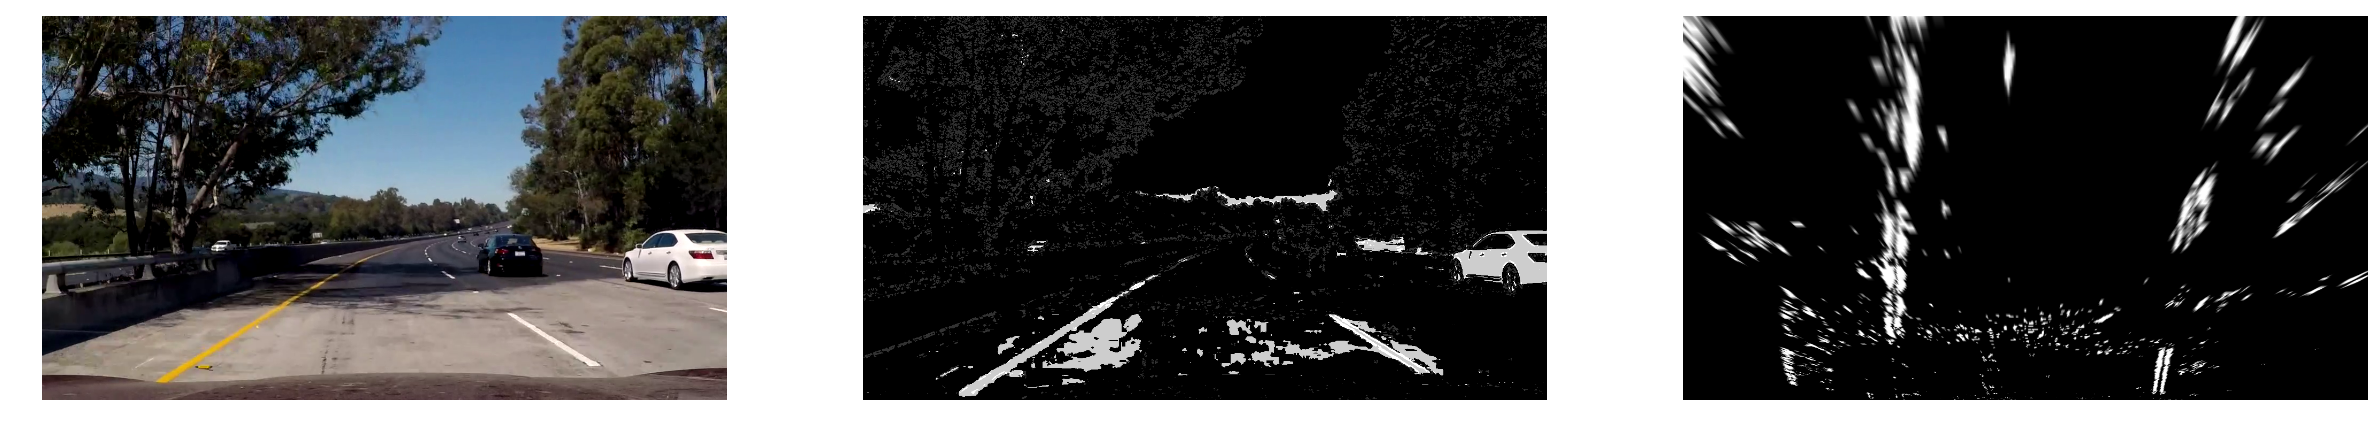

In [118]:
imagenames = glob.glob('snapshots/*.png')

lane_images = []

for ix, fname in enumerate(imagenames):
    img = mpimg.imread(fname)

    res1, res2 = apply_thresholds(img)
    res = res1*50 + res2*205
    
    res_rgb = np.dstack((res1*255, res1*255, res1*255))
    out = fast_unwarp_lane(res_rgb)

    plot_images([img, res, out])
    lane_images.append(out)
    

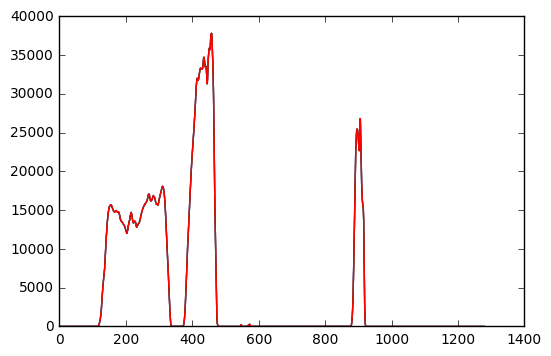

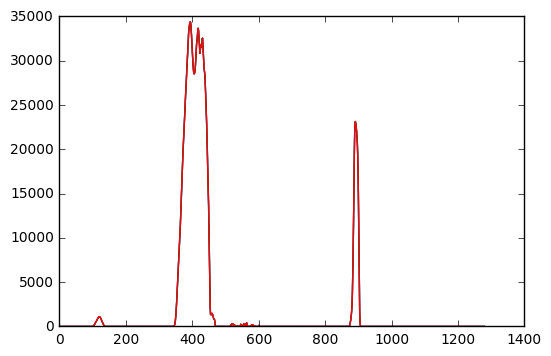

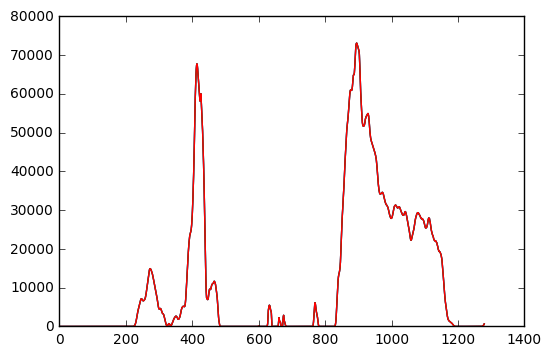

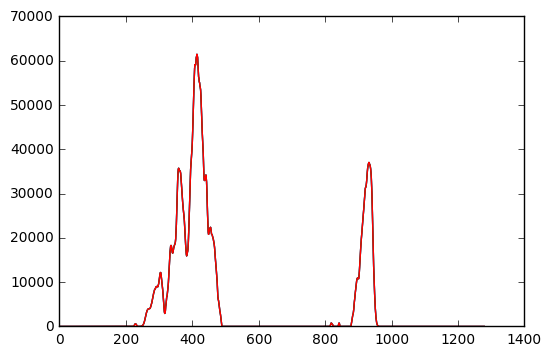

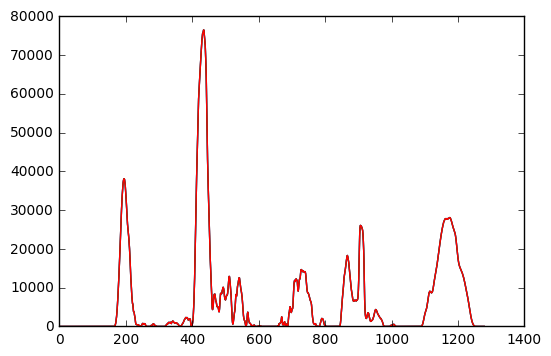

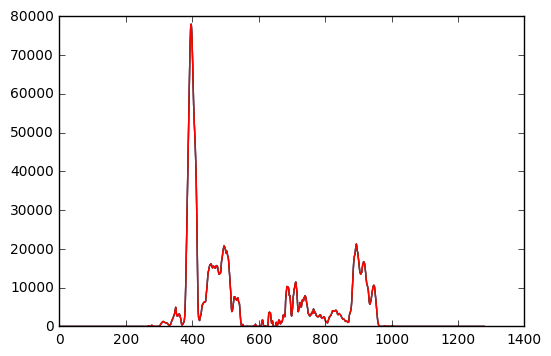

In [116]:
for lane in lane_images:
    histogram = np.sum(lane[lane.shape[0]/2:, :], axis=0)
    plt.plot(histogram)
    plt.show()